<h1 align="center">Time Series</h1>
<h3 align="center">Dataset: <a href="https://www.kaggle.com/c/competitive-data-science-predict-future-sales">Competitive data science: Predict future sales</a></h3>

In [1]:
import numpy   as np
import pandas  as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib notebook

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics       import mean_squared_error
import lightgbm as lgb

from itertools import product
import gc
import time

from ipywidgets import interact

In [2]:
!ls ../data/predict-future-sales

item_categories.csv       sales_train.csv.zip       shops.csv
items.csv.zip             sample_submission.csv.zip test.csv.zip


## Datos diarios de ventas desde Enero 2013 hasta Octubre 2015.

In [3]:
path = "../data/predict-future-sales/"

t = time.time()
train = pd.read_csv(path+"sales_train.csv.zip") # ventas diarias  Enero 2013 -> Octubre 2015
shops = pd.read_csv(path+"shops.csv")           # tiendas    (60)
items = pd.read_csv(path+"items.csv.zip")       # productos  (22170)
cats  = pd.read_csv(path+"item_categories.csv") # categorias de productos (84)
test  = pd.read_csv(path+"test.csv.zip", index_col="ID") # predicir Noviembre 2015
sub   = pd.read_csv(path+"sample_submission.csv.zip", index_col="ID")
print(round(time.time() - t,2), "secs")

1.78 secs


- **`sales_train.csv`** Filas: 2935849 ventas (Enero 2013 --> Octubre 2015)
  - **date**: date in format dd/mm/yyyy
  - **date_block_num**: a consecutive month number. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
  - **shop_id**: unique identifier of a shop
  - **item_id**: unique identifier of a product
  - **item_price**: current price of an item
  - **item_cnt_day**: number of products sold. You are predicting a monthly amount of this measure
- **`shops.csv`** Filas: 60 tiendas
  - **shop_id**
  - **shop_name**: name of shop (EN RUSO 🇷🇺)
- **`items.csv`** Filas: 22170 productos
  - **item_id**
  - **item_name**: name of item (EN RUSO 🇷🇺)
  - **item_category_id**: unique identifier of item category
- **`item_categories.csv`** Filas: 84 categorías de producto
  - **item_category_id**
  - **item_category_name**: name of item category (EN RUSO 🇷🇺)
- **`test.csv`** Filas 214200 pares unicos de (Shop, Item)
  - **ID**: an Id that represents a (Shop, Item) tuple within the test set
  - **shop_id**
  - **item_id**

In [4]:
train.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0


In [5]:
train.tail(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935847,22.10.2015,33,25,7440,299.0,1.0
2935848,03.10.2015,33,25,7460,299.0,1.0


# Objetivo Concurso Kaggle: Calcular Noviembre 2015
### Sólo tiene tienda y producto, pero no cantidades vendidas

In [6]:
test.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [7]:
#itemsProfile = pandas_profiling.ProfileReport(items)
#itemsProfile.to_file(outputfile="./DATA/items.html")

#shopsProfile = pandas_profiling.ProfileReport(shops)
#shopsProfile.to_file(outputfile="./DATA/shops.html")

#catsProfile = pandas_profiling.ProfileReport(cats)
#catsProfile.to_file(outputfile="./DATA/item_categories.html")

#trainProfile = pandas_profiling.ProfileReport(train)
#trainProfile.to_file(outputfile="./DATA/sales_train_v2.html")

#testProfile = pandas_profiling.ProfileReport(test)
#testProfile.to_file(outputfile="./DATA/test.html")

# Outliers - valores atípicos :
### Son observaciones cuyos valores son muy diferentes a las otras observaciones del mismo grupo de datos
- Gestión de valores nulos: origen, eliminar registros con valores nulos, imputar valores
- Columnas duplicadas ej. km - millas
- Columnas con un valor único
- ...

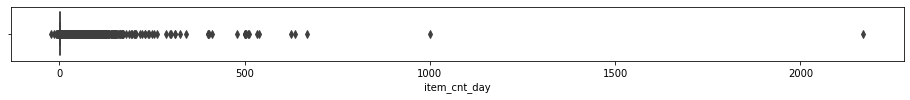

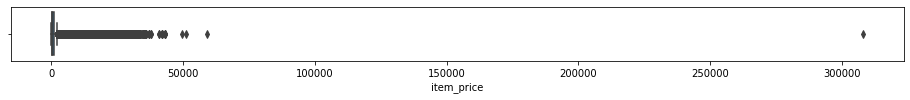

In [11]:
plt.figure(figsize=(16,1))
sb.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(16,1))
sb.boxplot(x=train.item_price);

In [12]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

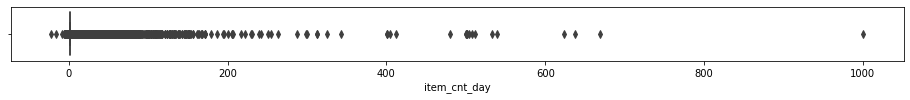

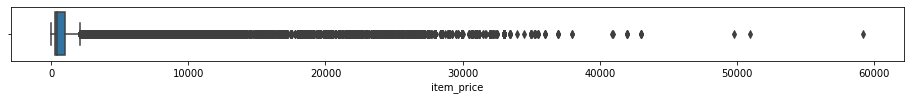

In [13]:
plt.figure(figsize=(16,1))
sb.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(16,1))
sb.boxplot(x=train.item_price);

# Precios negativos

In [14]:
train.loc[train.item_price<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [19]:
# ver otros precios para ese mes, tienda y producto
train[(train.shop_id==32)&
      (train.item_id==2973)&
      (train.date_block_num==4)&
      (train.item_price>0)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484682,23.05.2013,4,32,2973,1249.0,1.0
484684,06.05.2013,4,32,2973,2499.0,1.0


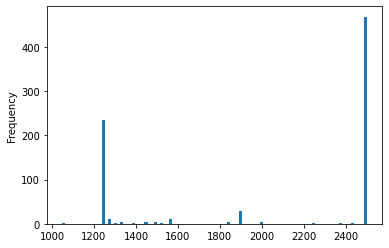

In [24]:
# ver otros precios para ese mes, tienda y producto
train[(train.item_id==2973)&(train.item_price>0)]["item_price"].plot.hist(bins=100)